建物データと浸水面標高ラスターデータから建物の被災データを生成。（必要手続き：Driveの接続）

3_CalcFloodDEMRaster.ipynbの実行後は再起動させる必要があります。

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title 日本の調査IDと自治体コードから住所情報を得る
#詳しくは https://www.e-stat.go.jp/gis/statmap-search?page=1&type=2&aggregateUnitForBoundary=A&toukeiCode=00200521&toukeiYear=2020&serveyId=A002005212020&coordsys=1&format=shape&datum=2000

survey_id = "A002005212020" #@param {type: "string"}
pref_code = "40" #@param
city_code = "202"  #@param
# "202" # 大牟田市
# "203" # 久留米市


In [ ]:
# @title 設定するパラメータ

# ケース名：解析を通して使います。
casename = "omuta-r2" # -giaj" #"kurume-r2" # "kurume-r2-GIAJ"

maxdepth = 7 #0 # Set 0 for GIAJ flood data

local_government_code = f"{pref_code}{city_code}"

# 確認用画像出力用フラグ
flg_checkDisp = False


In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

zoomlevel = 15 # DEM zoom level to fetch

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
#path_cgml = path_home + "/CityGML/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
path_upload = path_case + "ForUpload/"
json_buildings = path_case+"buildings_parsed.json"
json_boundary = path_case +"boundary.json"
file_bbox = path_case + "boundbox.npy"
file_dem_fmt = path_case + "dem_{}_{}-{}_{}-{}.npz"

file_flooddem = path_case + "flood_dem_{:04d}.npz"
file_flooddepth = path_case + "flood_depth_{:04d}.npz"

path_heattile_tmp = "heat/"

file_building_csv = path_upload + "buildings.csv"
file_floodHeattile_yukauemokuzou_zip = path_upload+"heatmap_yukaue_mokuzou.zip"
file_floodHeattile_yukashitamokuzou_zip = path_upload+"heatmap_yukashita_mokuzou.zip"
file_floodHeattile_allmokuzou_zip = path_upload+"heatmap_all_mokuzou.zip"

In [ ]:
# @title shapeファイルをダウンロードする．
%cd {path_home}
!mkdir shapes
%cd shapes

import requests
import re
from urllib.parse import unquote

# ダウンロードするファイルのURL
local_government_code = f"{pref_code}{city_code}"
url = f"https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId={survey_id}&code={local_government_code}&coordSys=1&format=shape&downloadType=5&datum=2000"

def get_filename_from_cd(cd):
    """
    Content-Dispositionヘッダーからファイル名を取得する関数
    """
    if not cd:
        return None
    fname = re.findall("filename\*=UTF-8''(.+)", cd)
    if len(fname) == 0:
        return None
    return unquote(fname[0])

# ファイルをダウンロードし保存する関数
def download_file(url):
    """
    指定されたURLからファイルをダウンロードし、Content-Dispositionヘッダーから取得したファイル名で保存する
    """
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        filename = get_filename_from_cd(response.headers.get('content-disposition'))
        if not filename:
            filename = 'downloaded_file.zip'
        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"ファイルがダウンロードされました: {filename}")
    return filename

# ファイルのダウンロード
shp_filename = download_file(url)

import os
shape_dir = os.path.splitext(shp_filename)[0]
!mkdir {shape_dir}
!unzip -o {shp_filename} -d {shape_dir}

%cd {path_home}
from glob import glob

address_shp = glob(f"shapes/{shape_dir}/*.shp")[0] # このコードの場所からみた住所のshpファイルの相対パス
shape_file = path_home + address_shp

/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR
mkdir: cannot create directory ‘shapes’: File exists
/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/shapes
ファイルがダウンロードされました: A002005212020DDSWC40202.zip
mkdir: cannot create directory ‘A002005212020DDSWC40202’: File exists
Archive:  A002005212020DDSWC40202.zip
  inflating: A002005212020DDSWC40202/r2ka40202.shp  
  inflating: A002005212020DDSWC40202/r2ka40202.shx  
  inflating: A002005212020DDSWC40202/r2ka40202.dbf  
  inflating: A002005212020DDSWC40202/r2ka40202.prj  
/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR


In [ ]:
# @title 主要ライブラリインポート
#!pip install git+https://github.com/eukarya-inc/plateauutils.git@main#egg=plateauutils
!pip install plateauutils
!pip install --upgrade numpy
!pip install --upgrade scikit-image
import json
import matplotlib.pyplot as plt
import numpy as np
from progressbar import progressbar
from shapely.geometry import MultiPolygon, shape, mapping, Point
!pip install rasterio
import rasterio
from rasterio.features import geometry_mask
import fiona
import csv
import sys
import shutil
from plateauutils.flood_converter.flood_to_png import FloodToPng
#sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

In [ ]:

!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
affine                           2.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bi

In [ ]:
# JSONファイルからデータを読み込む
with open(json_buildings, 'r') as f:
    buildings = json.load(f)

print(len(buildings))

90455


In [ ]:
try:
  print(buildings[0:10])
  print(len([vv for vv in buildings if vv["measured_height"] <2.1]))
except:
  pass

[{'gid': 'bldg_5bb0e545-ec27-4bdd-b4f5-ce88ac0802f0', 'center': [130.39681017603277, 33.00481616943035], 'min_height': 3.251, 'measured_height': None, 'building_structure_type': None, 'dem': nan}, {'gid': 'bldg_223b2a8f-c2f4-4d06-bfe9-b7795ebd9d9a', 'center': [130.3963708808834, 33.00190456995042], 'min_height': 5.253, 'measured_height': 2.6, 'building_structure_type': None, 'dem': 5.522831106867581}, {'gid': 'bldg_5b497c2a-fb59-424b-ac81-2d9c8355f5ed', 'center': [130.39730104480077, 33.00499391435827], 'min_height': 3.057, 'measured_height': None, 'building_structure_type': None, 'dem': 2.5878461692023644}, {'gid': 'bldg_3b3417a5-f869-4420-95f9-c1d6cbf30c9d', 'center': [130.3986860225292, 33.00550176708172], 'min_height': 2.657, 'measured_height': 2.1, 'building_structure_type': None, 'dem': 2.610875161877514}, {'gid': 'bldg_c06324bb-f540-4309-a779-8c428bfd84e5', 'center': [130.3996265232932, 33.00239327178217], 'min_height': 5.499, 'measured_height': 3.1, 'building_structure_type': N

In [ ]:
building_types = set([vv["building_structure_type"] for vv in buildings])
print(building_types)

{'軽量鉄骨造', '鉄筋コンクリート造', '鉄骨鉄筋コンクリート造', 'レンガ造・コンクリートブロック造・石造', '鉄骨造', '木造・土蔵造', None}


In [ ]:
#depth_map = np.load(file_flooddepth.format(int(maxdepth*100)))
dem_map = np.load(file_flooddem.format(int(maxdepth*100)))

In [ ]:
#lons = depth_map["lons"]
#lats = depth_map["lats"]
#depthmap = depth_map["floodmap_depth"]
lons = dem_map["lons"]
lats = dem_map["lats"]
demmap = dem_map["floodmap_dem"]

In [ ]:
#np.set_printoptions(threshold=np.inf)
print(lons)
print(lats)

[130.3527832  130.35282612 130.35286903 ... 130.51744938 130.51749229
 130.51753521]
[33.11909569 33.11905972 33.11902375 ... 32.99028909 32.99025312
 32.99021715]


In [ ]:
print(demmap)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
if flg_checkDisp:
  ax =plt.subplot(1,1,1)
  #img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
  img = ax.contourf(lons,lats, demmap)#,levels=np.arange(0,maxdepth+0.1,0.25))
  ax.axis("equal")
  plt.colorbar(img)
  #ax.set_xlim(130.4,130.5)
  #ax.set_ylim(33.22,33.32)

In [ ]:
bldgtype_yukaue_depth = {"木造・土蔵造":0.45, "レンガ造・コンクリートブロック造・石造":0.45, "不明":0.45}
bldgtype_mokuzou = ["木造・土蔵造"]
bldgtype_renga = [""]
bldgtype_block = ["レンガ造・コンクリートブロック造・石造"]
def get_floodcategory(bldg_type, depth):
  min_depth = bldgtype_yukaue_depth[bldg_type] if bldg_type in bldgtype_yukaue_depth else 0.0
  category = "非浸水"
  if depth is not None and depth >0:
    if depth > min_depth :
      if min_depth == 0:
        category = "浸水"
      else:
        category = "床上"
    elif depth > 0:
      category = "床下"
  if bldg_type in bldgtype_mokuzou:
    category += "（木造）"
  elif bldg_type in bldgtype_renga:
    category += "（レンガ造）"
  elif bldg_type == "不明" or bldg_type is None:
    category += "（不明）"
  else:
    category += "（非木造）"
  return category

In [ ]:
print(get_floodcategory("木造・土蔵造", 1) )
print(get_floodcategory("木造・土蔵造", 0.2) )
print(get_floodcategory("不明", 1) )
print(get_floodcategory("不明", 0.3) )
print(get_floodcategory("非木造", 1) )
print(get_floodcategory(None, -1) )
print(get_floodcategory(None, None) )

床上（木造）
床下（木造）
床上（不明）
床下（不明）
浸水（非木造）
非浸水（不明）
非浸水（不明）


In [ ]:
def calc_floatIdx_of_list(val:float, list):
  """
  Args:
      val (float): value which the method finds index for.
      list (array-like): must be ordered (ascending or descending)
  """
  try:
    if list[0] < list[-1]:
      idl = np.where(val > list)[0][-1]
    else:
      idl = np.where(val < list)[0][-1]
  except IndexError:
    print("IndexErrorCheck:", val, (list[0], list[-1]))
    return np.nan
  if idl == len(list) -1:
    return idl
  return idl + (val-list[idl])/(list[idl+1]-list[idl])
  #return (val - list[0])/(list[-1]-list[0]) * (len(list)-1)

def calc_interpval_of_list(idx:float, list):
  il = int(idx)
  ih = int(idx + 1)
  if ih >= len(list):
    return list[-1]
  dd = idx - il
  return (1-dd)*list[il] + dd*list[ih]

def calc_InterpVal_lonlat(lon, lat, data, lons, lats):
  #print("Check1: ", lon, lat)
  cx = calc_floatIdx_of_list(lon, lons)
  cy = calc_floatIdx_of_list(lat, lats)
  #print("Check: ", cx, cy, "\n")
  if np.any(np.isnan([cy, cx])):
    return np.nan
  xl = int(cx)
  yl = int(cy)
  xh = xl + 1
  dx = cx-xl
  yh = yl + 1
  dy = cy - yl
  if xh > len(lons)-1:
    xh = xl
  if yh > len(lats)-1:
    yh = yl
  val_ll = data[yl,xl]
  val_hl = data[yh,xl]
  val_lh = data[yl,xh]
  val_hh = data[yh, xh]
  return (1-dy)*(1-dx)*val_ll + (1-dy)*dx*val_lh + dy*(1-dx)*val_hl + dy*dx*val_hh

In [ ]:
print(lons[0], lons[-1])
print(lats[0], lats[-1])

130.352783203125 130.51753520965576
33.11909568798536 32.990217149508766


In [ ]:
#@title 住所付与の準備

# shpファイルのパス

# マルチポリゴンのバウンディングボックスを取得します。
minx, miny, maxx, maxy = lons.min(), lats.min(), lons.max(), lats.max() # [130.412497, 33.224723, 130.68759971, 33.40869805]
# ラスタライズのパラメータを設定します。
raster_height, raster_width = demmap.shape # (5376, 6656)

transform = rasterio.transform.from_origin(minx, maxy, (maxx-minx)/raster_width, (maxy-miny)/raster_height)

lookup_table = []

# shpファイルを開く
with fiona.open(shape_file, 'r') as src:
    with rasterio.MemoryFile() as memfile:
        with memfile.open(driver='GTiff',
                          height=raster_height,
                          width=raster_width,
                          count=1,
                          dtype='uint8',
                          crs=src.crs,
                          transform=transform) as dataset:
            combined_mask = np.empty((dataset.height, dataset.width))
            combined_mask[:] = np.nan
            for i, feature in enumerate(src):
                # 各フィーチャからジオメトリを取得し、shapelyオブジェクトに変換
                polygon = shape(feature['geometry'])
                mask = geometry_mask([mapping(polygon)],
                                      transform=dataset.transform,
                                      invert=True,
                                      out_shape=(dataset.height, dataset.width))
                combined_mask[mask] = i
                del mask

                # PREF_NAME 福岡県
                # CITY_NAME 久留米市
                # S_NAME 花畑三丁目
                pref_name = feature["properties"]["PREF_NAME"]
                city_name = feature["properties"]["CITY_NAME"]
                s_name = feature["properties"]["S_NAME"]
                lookup_table.append({
                    "id": i,
                    "address": s_name,
                    "vector": polygon
                })


#plt.imshow(combined_mask)

new_lons = np.linspace(lons.min(), lons.max(), raster_width)  # 経度
new_lats = np.linspace(lats.max(), lats.min(), raster_height)   # 緯度

def get_address_ids(lon, lat, combined_mask):
    #center_lon, center_lat = building['center']

    # 緯度経度からピクセル座標に変換
    #lons_to_pixel = np.searchsorted(lons, center_lon) - 1
    #lats_to_pixel = np.searchsorted(lats, center_lat) - 1
    lons_to_pixel = int(calc_floatIdx_of_list(lon, new_lons))
    lats_to_pixel = int(calc_floatIdx_of_list(lat, new_lats))

    # # 周囲のセルを調べるための正規分布を作成
    # x, y = np.meshgrid(np.arange(combined_mask.shape[1]), np.arange(combined_mask.shape[0]))
    # pos = np.dstack((x, y))
    # rv = multivariate_normal([lons_to_pixel, lats_to_pixel], [[1.22, 0], [0, 1.22]])
    # gaussian_mask = rv.pdf(pos)

    # # 正規分布からしきい値を超えるセルのIDを取得
    # # threshold = gaussian_mask.mean()
    # # ids = combined_mask[gaussian_mask > threshold]

    ids = combined_mask[lats_to_pixel-1:lats_to_pixel+2, lons_to_pixel-1:lons_to_pixel+2] # 中心と周囲8ピクセルを見る
    unique_ids = np.unique(ids[~np.isnan(ids)])  # np.nanを除外してユニークなIDを取得

    return unique_ids

def find_address(lon, lat, combined_mask):
      address_ids = get_address_ids(lon, lat, combined_mask)
      address = ""
      if len(address_ids) == 0:
          address = '不明'
      elif len(address_ids) == 1:
          address = lookup_table[int(address_ids[0])]['address']
      else:
          # 複数のIDがある場合の処理
          # lookup_tableのベクトルと照合して正しいIDを見つける処理
          center_point =  Point(lon, lat) # Point(building['center'][0], building['center'][1])
          possible_addresses = []

          for address_id in address_ids:
              for entry in lookup_table:
                  if entry['id'] == address_id:
                      polygon = shape(entry['vector'])
                      if polygon.contains(center_point):
                          possible_addresses.append(entry['address'])
                          break  # 最初にマッチしたアドレスでループを抜ける

          if possible_addresses:
              address = possible_addresses[0]  # 最初に見つかった住所を採用
          else:
              # どのポリゴンにも含まれなかったら周囲の住所を全て列挙
              address = " / ".join([entry['address'] for entry in lookup_table if entry['id'] in address_ids])
      return address

# 処理を実行
#buildings_with_address = assign_address(buildings, combined_mask)

In [ ]:
for bb in progressbar(buildings):
  lon, lat = bb["center"]
  #print(lon, lat)
  #depth = calc_InterpVal_lonlat(lon, lat, depthmap, lons, lats)
  dem = calc_InterpVal_lonlat(lon, lat, demmap, lons, lats)
  depth = dem - bb["min_height"] #  bb["dem"]
  bb["lon"] = bb["center"][0]
  bb["lat"] = bb["center"][1]
  #print(depth)
  bb["out"] = False
  bb["flood_category"] = get_floodcategory(bb["building_structure_type"], depth)
  bb["depth"] = depth
  if "非浸水" in bb["flood_category"]:
    bb["out"] = True
    bb["depth"] = None
  bb["address"] = find_address(lon,lat,combined_mask)

100% (90455 of 90455) |##################| Elapsed Time: 0:00:23 Time:  0:00:23


In [ ]:
print("2.1m未満：", len([bb for bb in buildings if bb["measured_height"] is None or bb["measured_height"] < 2.1]))
print([bb for bb in buildings if "非浸水" in bb["flood_category"]][0:10])

2.1m未満： 3400
[{'gid': 'bldg_5bb0e545-ec27-4bdd-b4f5-ce88ac0802f0', 'center': [130.39681017603277, 33.00481616943035], 'min_height': 3.251, 'measured_height': None, 'building_structure_type': None, 'dem': nan, 'lon': 130.39681017603277, 'lat': 33.00481616943035, 'out': True, 'flood_category': '非浸水（不明）', 'depth': None, 'address': '新港町'}, {'gid': 'bldg_223b2a8f-c2f4-4d06-bfe9-b7795ebd9d9a', 'center': [130.3963708808834, 33.00190456995042], 'min_height': 5.253, 'measured_height': 2.6, 'building_structure_type': None, 'dem': 5.522831106867581, 'lon': 130.3963708808834, 'lat': 33.00190456995042, 'out': True, 'flood_category': '非浸水（不明）', 'depth': None, 'address': '新港町'}, {'gid': 'bldg_5b497c2a-fb59-424b-ac81-2d9c8355f5ed', 'center': [130.39730104480077, 33.00499391435827], 'min_height': 3.057, 'measured_height': None, 'building_structure_type': None, 'dem': 2.5878461692023644, 'lon': 130.39730104480077, 'lat': 33.00499391435827, 'out': True, 'flood_category': '非浸水（不明）', 'depth': None, 'addres

In [ ]:
num_flooded = len([bb for bb in buildings if not bb["out"]])
num_yukashita = len([bb for bb in buildings if "床下" in bb["flood_category"]])

print(num_flooded,"(",num_yukashita,")/",len(buildings))

524 ( 47 )/ 90455


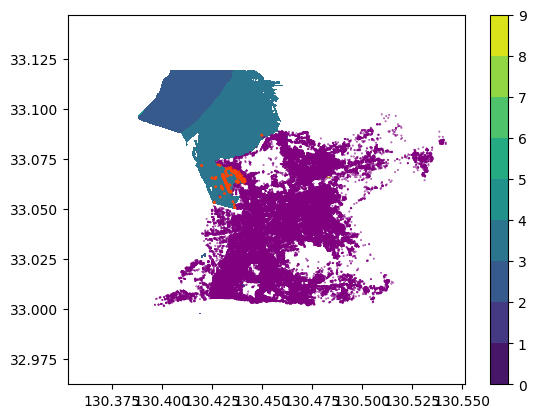

In [ ]:
if True :#flg_checkDisp:
  xx = [bb["center"][0] for bb in buildings]
  yy = [bb["center"][1] for bb in buildings]
  cc = ["orangered" if not bb["out"] else "purple" for bb in buildings]
  ss = [1 if not bb["out"] else 0.1 for bb in buildings]
  aa = [1 if not bb["out"] else 0.01 for bb in buildings]
  ax =plt.subplot(1,1,1)
  #img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
  img = ax.contourf(lons,lats, demmap)#,levels=np.arange(0,maxdepth+0.1,0.25))
  plt.scatter(xx,yy,c=cc,s=ss)#, alpha=aa)
  ax.axis("equal")
  #plt.xlim([130.50, 130.53])
  #plt.ylim([33.32, 33.34])
  plt.colorbar(img)
  plt.scatter

In [ ]:
!mkdir {path_upload}
csv_keylist = ['gid', 'lon', 'lat', 'min_height', 'flood_category','depth', 'address']
csv_header = ['gid', 'lon', 'lat', 'dem', 'flood_category','flood_depth', 'address']
with open(file_building_csv, "w") as ofile:
  ofile.write(",".join(f"'{w}'" for w in csv_header)+"\n")
  for bb in buildings:
    tempstr = ""
    for kk in csv_keylist:
      if isinstance(bb[kk], str):
        tempstr += f"'{bb[kk]}',"
      else:
        tempstr += f"{bb[kk]},"
    ofile.write(tempstr[:-1]+"\n")
    #print(tempstr[:-1])


In [ ]:
print(lons,lats)
print(lons[-1])

[130.3527832  130.35282612 130.35286903 ... 130.51744938 130.51749229
 130.51753521] [33.11909569 33.11905972 33.11902375 ... 32.99028909 32.99025312
 32.99021715]
130.51753520965576


In [ ]:
def dump2heatmap(lons, lats, buildings):
  gauss_hl = 63
  xx, yy = np.meshgrid(np.arange(-gauss_hl,gauss_hl+1),np.arange(-gauss_hl,gauss_hl+1))
  #gauss = 1/(2045*np.pi)*np.exp(-(xx**2+yy**2)/2048) # sigma = 32 px
  gauss = np.sqrt((xx**2+yy**2)) <= 31 #gauss_hl
  #print(np.shape(gauss))
  maxx = len(lons)
  maxy = len(lats)
  heatmap = np.zeros((maxy, maxx))
  for bb in buildings:
    if not bb["out"]:
      lon, lat = bb["center"]
      idx = int(calc_floatIdx_of_list(lon, lons))
      idy = int(calc_floatIdx_of_list(lat, lats))
      gxl, gxh = 0, gauss_hl*2 + 1
      gyl, gyh = 0, gauss_hl*2 + 1
      idxl, idxh = idx-gauss_hl, idx+gauss_hl+1
      idyl, idyh = idy-gauss_hl, idy+gauss_hl+1
      if idxl < 0:
        gxl = - idxl
        idxl = 0
      if idxh > maxx:
        gxh = idxh - maxx
        idxh = maxx
      if idyl < 0:
        gyl = - idyl
        idyl = 0
      if idyh > maxy:
        gyh = idyh - maxy
        idyh = maxy
      #print(idyl,idyh,idxl,idxh,gyl,gyh,gxl,gxh)
      heatmap[idyl:idyh,idxl:idxh] += gauss[gyl:gyh,gxl:gxh]
  return heatmap/(np.sum(gauss)*16) * 10000

In [ ]:
yukaue_mokuzou = dump2heatmap(lons, lats, [bb for bb in buildings if bb["flood_category"]=="床上（木造）"])
yukashita_mokuzou = dump2heatmap(lons, lats, [bb for bb in buildings if bb["flood_category"]=="床下（木造）"])
all_mokuzou = dump2heatmap(lons, lats, [bb for bb in buildings if "（木造）" in bb["flood_category"]])

In [ ]:
print(np.nansum(yukaue_mokuzou))
print(np.nansum(yukashita_mokuzou))
print(np.nansum(all_mokuzou))


115625.00000000003
28750.000000000015
144375.0000000001


In [ ]:
if flg_checkDisp:
  chech_heatmap = all_mokuzou
  ax =plt.subplot(1,1,1)
  plt_dens = np.copy(chech_heatmap)
  plt_dens[chech_heatmap==0] = np.nan
  img = ax.pcolormesh(lons,lats, plt_dens)
  ax.axis("equal")
  plt.xlim([130.50, 130.53])
  plt.ylim([33.32, 33.34])
  plt.colorbar(img)

In [ ]:
#@title XYZタイル分けされた点郡NPZファイルの生成関数
#print(len(lats)/256.0, len(lons)/256.0)

def save_tile_npz(lats,lons,map, classificationmap, zoom=15, dst_dir ="temp/"):
  dir_zoom = dst_dir + f"{zoom}/"
  if not os.path.exists(dir_zoom):
    os.makedirs(dir_zoom)
  res_lons = np.array([])
  res_lats = np.array([])
  res_maps = np.array([])
  res_class = np.array([])
  print(f" / total loop num: {len(lats)/256}")
  for jj, tmp_lat in progressbar(enumerate(lats[::256])):
    idj = jj*256
    sublats = lats[idj:idj+256]
    for ii, tmp_lon in enumerate(lons[::256]):
      idi = ii*256
      sublons = lons[idi:idi+256]
      xx,yy  = pfsl.calc_xyz_from_lonlat(tmp_lon, tmp_lat, zoom)
      #print(ii,jj, xx, yy)
      submap = map[idj:idj+256,idi:idi+256]
      subclass = classificationmap[idj:idj+256,idi:idi+256]
      grd_lons, grd_lats  = np.meshgrid(sublons,sublats)
      flt_lons = grd_lons.ravel()
      flt_lats = grd_lats.ravel()
      flt_map = submap.ravel()
      flt_class = subclass.ravel()
      #selected = [[lon,lat,dem] for lon, lat, dem in zip(flt_lons, flt_lats,flt_map) if not np.isnan(dem)]
      #print(flt_lons[0:5])
      #print(flt_lats[0:5])
      #print(flt_map[0:5])
      #print(ii, jj, f"{subzoom}-{xx}-{yy}", f"{subzoom}-{chk_tile[0]}-{chk_tile[1]}")
      if not os.path.exists(f"{dir_zoom}{xx}"):
        os.mkdir(f"{dir_zoom}{xx}")
      np.savez(f"{dir_zoom}{xx}/{yy}.npz", lons=flt_lons, lats=flt_lats, dem=flt_map, classification=flt_class)
      res_lons = np.append(res_lons, flt_lons)
      res_lats = np.append(res_lats, flt_lats)
      res_maps = np.append(res_maps, flt_map)
      res_class = np.append(res_class, flt_class)
  return res_lons, res_lats, res_maps, res_class


In [ ]:
worklist = [
  [yukaue_mokuzou, file_floodHeattile_yukauemokuzou_zip],
  [yukashita_mokuzou, file_floodHeattile_yukashitamokuzou_zip],
  [all_mokuzou, file_floodHeattile_allmokuzou_zip]
]
for heatmap, savefile in worklist:
  print(f"for {savefile}")
  #print(np.nansum(heatmap))
  category = np.zeros_like(heatmap)
  levels = [5, 10, 15, 20, 25]
  for ii, ll in enumerate(levels[::-1]):
    category[heatmap<ll] = len(levels)-ii
  category[heatmap==0] = 0
  category[heatmap>levels[-1]] = len(levels)+1
  heatmap[heatmap==0] = np.nan
  if os.path.exists("/heat_tmp"):
    !rm -rf /heat_tmp
  test_lons, test_lats, test_maps, test_class = save_tile_npz(lats,lons,heatmap,category,dst_dir="/heat_tmp/")
  if os.path.exists("/heattile_tmp/"):
    !rm -rf /heattile_tmp
  p = FloodToPng("/heat_tmp/")
  p.parse("/heattile_tmp/")
  shutil.make_archive(savefile[:-4], 'zip', "/heattile_tmp/")
  #!rm -rf "heat_tmp"
  #!rm -rf "heattile_tmp"

for /content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/omuta-r2/ForUpload/heatmap_yukaue_mokuzou.zip


/ |#                                                  | 0 Elapsed Time: 0:00:00

 / total loop num: 14.0


| |     #                                            | 13 Elapsed Time: 0:00:19


for /content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/omuta-r2/ForUpload/heatmap_yukashita_mokuzou.zip


- | #                                                 | 1 Elapsed Time: 0:00:00

 / total loop num: 14.0


| |      #                                           | 13 Elapsed Time: 0:00:19


for /content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/omuta-r2/ForUpload/heatmap_all_mokuzou.zip


- | #                                                 | 1 Elapsed Time: 0:00:00

 / total loop num: 14.0


| |        #                                         | 13 Elapsed Time: 0:00:19
